In [104]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# project specific libs
import os
import matplotlib.pyplot as plt

In [105]:
# set (local) path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/ampaim/'

In [106]:
###
# Load AB mapping file
###

# get AMPAIM+EISER mapping file w metadata; drop row 1
df_map_AB = pd.read_csv(path + 'inputs/adamcantor22_Cross_Disease_Pilot_0/Qiime2_0/qiime_mapping_file.tsv', sep='\t', header=0, index_col=0)

# get first row for any future operations
first_row = df_map_AB.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map_AB = df_map_AB.iloc[1:,]


###
# Specific replacements
###

# 526-0-twin-psaplate308 is missing a dash
df_map_AB = df_map_AB.rename(index={'526-0-twin-psaplate308': '526-0-twin-psa-plate308'})

###
# General replacements
###

# refrain from dropping NA's because you might need the columns for Q2 and you need to smoothly concat the first row

# convert index to str from float etc.
df_map_AB.index = df_map_AB.index.map(str)

# switch EISER diagnosis to eiser from NA
df_map_AB.loc[df_map_AB['Project'] == 'eiser', 'Diagnosis'] = 'eiser'

# RBB mapping file doesn't have info on duplicate controls, and the glass control info is extracted only from a subset of the names
# so we need to grab that info from AB's mapping file
samp_to_ctrlstatus = df_map_AB['Project'].to_dict()

# grab AB non-microteach samples
df_map_AB_filt = df_map_AB[df_map_AB['Project'].isin(['eiser','TWIN_PSA','glass_control','neg_control','duplicate_control'])]

df_map_AB_filt.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
#SampleID,,,,,,,,,,,,,,,,,,,,,
116783-plate305,CCTCGCATGACC,CCGGACTACHVGGGTWTCTAAT,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116783,NaN,NaN,fecal,NaN,NaN,NaN
116784-plate305,CGCGCAAGTATT,CCGGACTACHVGGGTWTCTAAT,B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116784,NaN,NaN,fecal,NaN,NaN,NaN
116785-plate305,AAGGCGCTCCTT,CCGGACTACHVGGGTWTCTAAT,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116785,NaN,NaN,fecal,NaN,NaN,NaN
116786-plate305,CGCAATGAGGGA,CCGGACTACHVGGGTWTCTAAT,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116786,NaN,NaN,fecal,NaN,NaN,NaN
116787-plate305,ACGGCGTTATGT,CCGGACTACHVGGGTWTCTAAT,E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116787,NaN,NaN,fecal,NaN,NaN,NaN


In [107]:
###
# Prepare for merge with RB mapping file
###

# load RB mapping file
df_map_RB = pd.read_csv(path + 'inputs/qiime_mapping_file_final_062123_RBB_ESR_CRPmod.csv', index_col=0)

# skip row with q2types; 140 columns
df_map_RB = df_map_RB.iloc[1:,]

# exclude unaffected since we are using TWINS_PSA from AB and controls from AB
# we only want microteach samples
df_map_RB = df_map_RB[df_map_RB['Diagnosis'].isin(['healthy','ss','sle','cd','RA','psa','pso'])]

# drop duplicate samples that appear in AB and that are controls per AB mapping file
# for s in list(df_map_RB.index.values):
#    if samp_to_ctrlstatus[s] in ['glass_control','duplicate_control','neg_control']:
#      df_map_RB = df_map_RB.drop(s)
        
        
# merge with AB
df_meta = pd.concat([df_map_AB_filt, df_map_RB], axis=0)

# drop 'Separate' and 'Together'; presumably Q2 artifacts
df_meta = df_meta.drop(['Separate','Together'], axis=1)

# add in Project col from AB that describes controls
df_meta['Project'] = df_meta.index.map(samp_to_ctrlstatus)

# grab eiser samples
eiser_id = list(df_meta[df_meta['Project'] == 'eiser'].index.values)

# drop eiser
df_meta = df_meta[df_meta['Project'] != 'eiser']

# drop nonunique values 
df_meta = df_meta.reset_index().drop_duplicates(subset='#SampleID').set_index('#SampleID')
'''
EARA14-V1-glass-plate308         2
MicraHC-1017-B-glass-plate308    2
MicraHC-1019-B-glass-plate308    2
MicraHC-1018-B-glass-plate308    2
MicraHC-1021-B-glass-plate308    2
MicraHC-1020-B-glass-plate308    2
EARA16-V1-glass-plate308         2
'''

### 
# General replacements
###

# specify float cols for later
float_cols = ['Age','BSA','CRP','DAS28','ESR','PhysicianGlobalPsA','RAPID3','SJC','TJC']

# Replace Y,N with 1,0 
df_meta = df_meta.replace({'Y':1,'N':0})

# create dict mapping diagnosis to samples
diag_to_samp = {}
for d in list(set(df_meta['Diagnosis'].values)):
    diag_to_samp[d] = list(df_meta[df_meta['Diagnosis'] == d].index.values)

print('Done')

Done


In [121]:
# grab glass_control sample IDs
# unique mappings
glass_to_og = {'EARA14-V1-glass-plate308': 'EARA14-V1-plate307',
 'EARA16-V1-glass-plate308': 'EARA16-V1-plate307'}

# sub mappings
df_gc = df_meta[df_meta['Project'] == 'glass_control']
df_gc = df_gc.drop(['EARA14-V2-plate308', 'EARA16-V2-plate308'])
gc_ids = list(df_gc.index.unique().values)
og_ids = list(df_meta.index.values)
for i in gc_ids:
    candidate_id = i.replace('glass-','')
    if candidate_id in og_ids:
        glass_to_og[i] = candidate_id


glass_to_og        
#og_id_candidates


{'EARA14-V1-glass-plate308': 'EARA14-V1-plate307',
 'EARA16-V1-glass-plate308': 'EARA16-V1-plate307',
 'EARA14-V2-glass-plate308': 'EARA14-V2-plate308',
 'EARA16-V2-glass-plate308': 'EARA16-V2-plate308',
 'MicraHC-1017-B-glass-plate308': 'MicraHC-1017-B-plate308',
 'MicraHC-1018-B-glass-plate308': 'MicraHC-1018-B-plate308',
 'MicraHC-1019-B-glass-plate308': 'MicraHC-1019-B-plate308',
 'MicraHC-1020-B-glass-plate308': 'MicraHC-1020-B-plate308',
 'MicraHC-1021-B-glass-plate308': 'MicraHC-1021-B-plate308'}

In [122]:
# subset df_meta on the keys and values
# create column glass_pair, G1, G2, etc.
# add to df_meta
id_to_label = {}
glass_pairs = []
for i, key in enumerate(list(glass_to_og.keys())):
    label = 'G' + str(i)
    glass_pairs.append(label)
    id_to_label[key] = label
    id_to_label[glass_to_og[key]] = label

df_meta['glass_pair'] = df_meta.index.map(id_to_label)

df_meta


,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,SpecimenType,UberonCodeType,Weight,WeightDateCollected,CCPpos,Disease,DiseaseDurationYears,OtherSubjectID,RFpos,glass_pair
#SampleID,,,,,,,,,,,,,,,,,,,,,
116807-2-plate308,AATGGTTCAGCA,CCGGACTACHVGGGTWTCTAAT,H8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fecal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116808-2-plate308,AATGCGCGTATA,CCGGACTACHVGGGTWTCTAAT,C9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fecal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116809-2-plate308,AATCTTGCGCCG,CCGGACTACHVGGGTWTCTAAT,D9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fecal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149960-2-plate308,GACTCAACCAGT,CCGGACTACHVGGGTWTCTAAT,A9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fecal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149961-2-plate308,TGAGACCCTACA,CCGGACTACHVGGGTWTCTAAT,E9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fecal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769-slesjo-plate308,CGGGACACCCGA,CCGGACTACHVGGGTWTCTAAT,C2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fecal,NaN,NaN,NaN,NaN,disease,NaN,769,NaN,NaN
2771-slesjo-plate308,ACCTTACACCTT,CCGGACTACHVGGGTWTCTAAT,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fecal,NaN,NaN,NaN,NaN,disease,NaN,2771,NaN,NaN
2948-slesjo-plate308,GTAGTAGACCAT,CCGGACTACHVGGGTWTCTAAT,E2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fecal,NaN,NaN,NaN,NaN,disease,NaN,2948,NaN,NaN


1.4307804792707484 0.19037071434735298


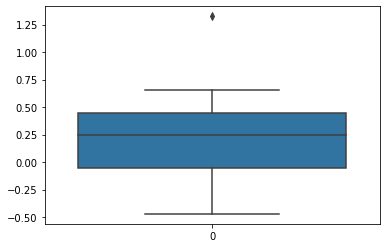

In [123]:
# get adiv Qiime2_0_KB_fix66/shannon.tsv
df_adiv = pd.read_csv(path + 'inputs/Qiime2_0_KB_fix66/shannon.tsv', sep='\t')
df_adiv = df_adiv.loc[1:,:]
df_adiv = df_adiv.set_index('id')
adiv = df_adiv['shannon_entropy']

# calculate adiv paired distances mean!=0 or difference between any two values / distances
df_meta_adiv = pd.concat([df_meta, adiv], axis=1)

# original - glass
adiv_diff = []
for g in glass_to_og:
    # diff of original - glass
    adiv_diff.append(float(df_meta_adiv.loc[glass_to_og[g],'shannon_entropy']) - float(df_meta_adiv.loc[g,'shannon_entropy']))
    

# conduct one sample t-test, same as ttest_rel
# https://stats.stackexchange.com/questions/507018/t-test-difference-between-p-values-of-stats-ttest-1samp-stats-ttest-rel-a
t,p = scipy.stats.ttest_1samp(a=adiv_diff,popmean=0)
print(t,p)
sns.boxplot([adiv_diff])

# CONCLUSION: original tends to have higher alpha div than respective glass control, but not statistically significant

-10.639503031100354 1.9584186274960722e-25


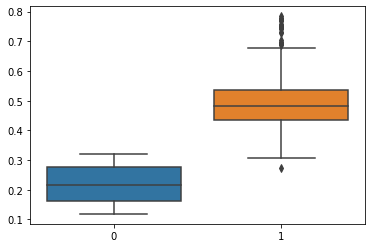

In [137]:
# get bdiv
# paired beta div: unweighted distances to compare inter-control vs inter-everything-else
df_beta = pd.read_csv(path + 'inputs/Qiime2_0_KB_fix66/core_metrics_results/distance-matrix.tsv', sep='\t', index_col=0)

intra_glass = []
# get distances of glass
for g in glass_to_og:
    intra_glass.append(df_beta.loc[g,glass_to_og[g]])


# drop eiser samples from columns and glass+normal from columns, then take only glass rows 
df_beta_drop = df_beta.drop(eiser_id, axis=1)
df_beta_drop = df_beta_drop.drop(list(glass_to_og.keys()), axis=1)
df_beta_drop = df_beta_drop.drop(list(glass_to_og.values()), axis=1)

# glass ids
glass_ids = list(glass_to_og.keys())

# get distances
glass_to_other_dist = df_beta_drop.loc[glass_ids,:].values.flatten()

t, p = scipy.stats.ttest_ind(intra_glass, glass_to_other_dist)
print(t, p)

sns.boxplot([intra_glass, glass_to_other_dist])

In [ ]:
# paired beta div: unweighted distances to compare inter-twin vs inter-disease distances
# paired shannon diversity difference from 0 
df_beta = pd.read_csv(path + 'inputs/Qiime2_0_KB/core_metrics_10k/unweighted_unifrac_distance_matrix.tsv', sep='\t', index_col=0)

# grab twin to pair dict
pair_to_ids = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    id_UA = str(df[df['Diagnosis'] == 'Unaffected'].index.values[0])
    id_RA = str(df[df['Diagnosis'] == 'RA'].index.values[0])
    pair_to_ids[p] = (id_UA, id_RA)

# get distances for each twin pair per beta div matrix    
pair_to_dist = {}
for p in list(df_alpha.TwinPair.values):
    id_UA, id_RA = pair_to_ids[p]
    pair_to_dist[p] = df_beta.loc[id_UA, id_RA]

df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Unweighted_Dist'])
df_paired_beta = df_paired_beta.drop('T1')

# grab inter RA distances
df_raw = pd.read_csv(path + 'inputs/Qiime2_0_KB/unweighted_raw_data.tsv', sep='\t', index_col=0)
df_RA = df_raw[df_raw['Group1'] == 'RA']
df_RA = df_RA[df_RA['Group2'] == 'RA']

# compare distances
inter_twin = df_paired_beta['Unweighted_Dist'].values
inter_RA = df_RA['Distance'].values

